# Test FewsTimeSeries and FewsTimeSeriesCollection



In [1]:
import sys
sys.path.append("..")
import hkvfewspy as fewspy
import matplotlib.pyplot as plt
import os
import pandas as pd

## `FewsTimeSeries`

Import first series from Fews Pi-XML file. Even though file contains two series `FewsTimeSeries` will only import the first series in the file. 

In [3]:
fews_ts = fewspy.schemas.timeseries.FewsTimeSeries.from_pi_xml("./test_2_series.xml")

Plot the series by calling plot on the FewsTimeSeries object (plot is passed on to the `plot` function in pandas for Series and DataFrames).

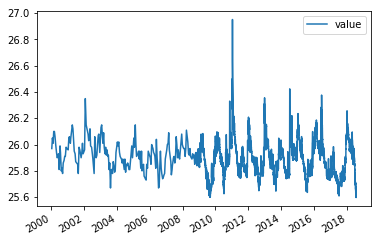

In [4]:
fews_ts.plot(y="value")
plt.show()

View metadata:

In [5]:
fews_ts.header

{'type': 'instantaneous',
 'moduleInstanceId': 'test_A1',
 'locationId': 'A1',
 'parameterId': 'series',
 'timeStep': None,
 'startDate': None,
 'endDate': None,
 'missVal': 'NaN',
 'stationName': 'test_A1',
 'lat': '52.0',
 'lon': '5.00',
 'x': '200000.0',
 'y': '340000.0',
 'units': 'm'}

In [6]:
fews_ts.to_pi_xml("./temp_1series.xml")

## `FewsTimeSeriesCollection`
To import all series from a Fews Pi-XML file, use `FewsTimeSeriesCollection`:

In [7]:
fews_ts_collection = fewspy.schemas.timeseries.FewsTimeSeriesCollection.from_pi_xml("./test_2_series.xml")

Timeseries are collected in a DataFrame with header data as columns and the series in the events column:

In [8]:
fews_ts_collection.timeseries

,endDate,events,lat,locationId,lon,missVal,moduleInstanceId,parameterId,startDate,stationName,timeStep,type,units,x,y
0,None,<hkvfewspy.schemas.timeseries.FewsTimeSeries o...,52.0,A1,5.00,NaN,test_A1,series,None,test_A1,None,instantaneous,m,200000.0,340000.0
1,None,<hkvfewspy.schemas.timeseries.FewsTimeSeries o...,51.0,A2,6.0,NaN,test_A2,series,None,test_A2,None,instantaneous,m,200000.0,350000.0


Loop through timeseries to plot

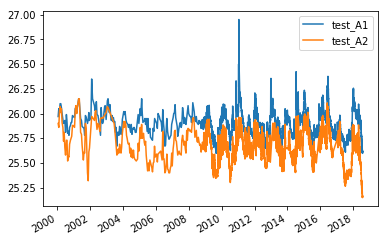

In [9]:
fig, ax = plt.subplots(1, 1)
for i in range(fews_ts_collection.timeseries.shape[0]):
    series = fews_ts_collection.timeseries.events.iloc[i]
    series.plot(y="value", ax=ax, label=series.header["stationName"])
    
plt.show()

Note that the objects stored in the timeseries DataFrame in the events column are actually `FewsTimeSeries` objects. This means that our earlier FewsTimeSeries object should be the same as the first timeseries in our FewsTimeSeriesCollection.

In [10]:
fews_ts_collection.timeseries.events[0]

We will now test whether the FewsTimeSeries in the collection is the same as the single timeseries we imported earlier. But first, it is important to realize that when we wrote our earlier `FewsTimeSeries` object `fews_ts` to XML the header (endDate and startDate) were automatically updated from the data. We will do the same for the first timeseries in the `FewsTimeSeriesCollection` object.

In [11]:
# get start and end date from timeseries and update header
fews_ts_collection.timeseries.events[0]._update_header_dates()

Now test for equality:

In [12]:
fews_ts_collection.timeseries.events[0] == fews_ts

True

It is possible to add data to the collection with the `add_series` method

In [13]:
help(fews_ts_collection.add_series)

Help on method add_series in module hkvfewspy.schemas.timeseries:

add_series(dfseries, metadata) method of hkvfewspy.schemas.timeseries.FewsTimeSeriesCollection instance
    Add series to PiTimeSeries object.
    
    Parameters
    ----------
    dfseries: pd.DataFrame
        Timeseries to add, must have DateTimeIndex and have columns with name "value" and "flag"
    
    metadata: dict
        dictionary containing header. Common entries values for include 'x', 'y', 'lat', lon',
        'missVal', 'stationName', 'type', 'units', 'moduleInstanceId', 'qualifierId', 'parameterId',
        'locationId'
    
    Notes
    -----
    It is unclear whether the entries in header are required or optional.
    Some possible values for header entries are shown below
    in case they need to be supplied:
    - 'missVal': np.nan
    - 'stationName': np.nan
    - 'units': 'm'
    - 'type': 'instantaneous'



Use data from first timeseries as "new" series:

In [14]:
new_series = fews_ts.timeseries
new_metadata = fews_ts.header

In [15]:
fews_ts_collection.add_series(new_series, new_metadata)

View our added timeseries in the DataFrame:

In [16]:
fews_ts_collection.timeseries

,endDate,events,lat,locationId,lon,missVal,moduleInstanceId,parameterId,startDate,stationName,timeStep,type,units,x,y
0,None,<hkvfewspy.schemas.timeseries.FewsTimeSeries o...,52.0,A1,5.00,NaN,test_A1,series,None,test_A1,None,instantaneous,m,200000.0,340000.0
1,None,<hkvfewspy.schemas.timeseries.FewsTimeSeries o...,51.0,A2,6.0,NaN,test_A2,series,None,test_A2,None,instantaneous,m,200000.0,350000.0
2,2018-07-27 01:00:00,<hkvfewspy.schemas.timeseries.FewsTimeSeries o...,52.0,A1,5.00,NaN,test_A1,series,2000-01-17 00:00:00,test_A1,None,instantaneous,m,200000.0,340000.0


We can write the FewsTimeSeriesCollection to file with the same command as before:

In [17]:
fews_ts_collection.to_pi_xml("./temp_3series.xml")

## Querying a FEWS database and returning FewsTimeSeries objects

In [17]:
# set client
pi = fewspy.pi
pi.setClient(wsdl='http://localhost:8081/FewsPiService/fewspiservice?wsdl') 

In [18]:
query = pi.setQueryParameters(prefill_defaults=True)

In [31]:
query.parameterIds(['P.meting.dagcal'])
query.moduleInstanceIds(['ImportCAW'])
query.locationIds(['66011cal'])
query.startTime(pd.datetime(2010,1,1))
query.endTime(pd.datetime(2018,7,1))
query.clientTimeZone('Europe/Amsterdam')
query.query["onlyManualEdits"] = False

In [32]:
query.query

{'convertDatum': False,
 'forecastSearchCount': 0,
 'importFromExternalDataSource': False,
 'omitMissing': False,
 'onlyHeaders': False,
 'showEnsembleMemberIds': False,
 'showStatistics': False,
 'showThresholds': False,
 'useDisplayUnits': True,
 'version': '1.22',
 'parameterIds': ['P.meting.dagcal'],
 'moduleInstanceIds': ['ImportCAW'],
 'locationIds': ['66011cal'],
 'startTime': datetime.datetime(2010, 1, 1, 0, 0),
 'endTime': datetime.datetime(2018, 7, 1, 0, 0),
 'clientTimeZone': 'Europe/Amsterdam',
 'onlyManualEdits': False}

In [33]:
fews_ts2_coll = pi.getFewsTimeSeries(queryParameters=query)

In [34]:
fews_ts2_coll

In [46]:
fews_ts2_coll.timeseries

,endDate,events,lat,locationId,lon,missVal,moduleInstanceId,parameterId,startDate,stationName,timeStep,type,units,x,y
0,None,<hkvfewspy.timeseries.FewsTimeSeries object at...,52.21196741287045,66011cal,5.04227195598427,-999.0,ImportCAW,P.meting.dagcal,None,KNMI Loenen aan de vecht,None,accumulative,mm,131425.0,469375.0


We queried specifically to get one timeseries, so extract FewsTimeSeries object from the collection:

In [40]:
fews_ts2 = fews_ts2_coll.timeseries.events[0]

In [42]:
fews_ts2.header

{'type': 'accumulative',
 'moduleInstanceId': 'ImportCAW',
 'locationId': '66011cal',
 'parameterId': 'P.meting.dagcal',
 'timeStep': None,
 'startDate': None,
 'endDate': None,
 'missVal': '-999.0',
 'stationName': 'KNMI Loenen aan de vecht',
 'lat': '52.21196741287045',
 'lon': '5.04227195598427',
 'x': '131425.0',
 'y': '469375.0',
 'units': 'mm'}

In [44]:
fews_ts2.timeseries.head()

,flag,value
2009-12-31 09:00:00,8.0,-999.0
2010-01-01 09:00:00,8.0,-999.0
2010-01-02 09:00:00,8.0,-999.0
2010-01-03 09:00:00,8.0,-999.0
2010-01-04 09:00:00,8.0,-999.0


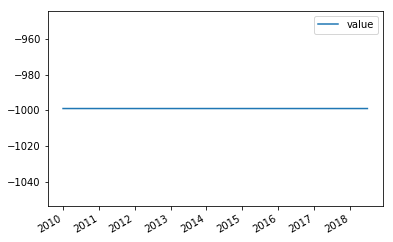

In [45]:
fews_ts2.plot(y="value")